In [11]:
!pip install tensorflow_text

     |████████████████████████████████| 4.4 MB 7.2 MB/s 


In [12]:

import pandas as pd
import numpy as np
import os, io, json
import pickle

import typing
from typing import Any, Tuple

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow_text as tf_text
from tensorflow.keras import models, layers, preprocessing as kprocessing

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:

try: # detect TPUs
  tpu = None
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPUs
  #strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
  #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  strategy = tf.distribute.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.124.33.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.124.33.26:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of accelerators:  8


In [123]:
# enter valid paths for hindi_joined.csv , model weights

path_dataset = "/content/drive/MyDrive/Dataset/Dakshina/hi/hindi_joined.csv"
pth_modell =  "/content/drive/MyDrive/Dataset/Dakshina/hi/tensorflow/sent_mod_1/weights.h5"

In [125]:
class DataProcessExclusive():
  def __init__(self,filepath):
    self.df = pd.read_csv(filepath,index_col=[0])
    self.hindi = df['Hindi']
    self.roman = df['roman']
    self.tokenizer_hi = None
    self.tokenizer_en=None
    self.x = None
    self.y = None
    self.preprocess(4)
  
  def preprocess(self,max_words):
    self.hi = self.shorten(self.hindi,max_words)
    self.en = self.shorten(self.roman,max_words)
    
    hi2 = self.pre_hi(self.hi)
    en2 = self.pre_en(self.en)
    
    tokenizer_hi =  Tokenizer(num_words=5000,char_level=True,oov_token='<UNK>' )
    tokenizer_en =  Tokenizer(num_words=5000,char_level=True,oov_token='<UNK>' )

    tokenizer_hi.fit_on_texts(hi2)
    tokenizer_en.fit_on_texts(en2)

    self.tokenizer_hi = self.update_tokenizer(tokenizer_hi)
    self.tokenizer_en = self.update_tokenizer(tokenizer_en)

    hi2 = self.tokenizer_hi.texts_to_sequences(hi2)
    en2 = self.tokenizer_en.texts_to_sequences(en2)

    hi2 = self.add_spcl_tokens(hi2,self.tokenizer_hi.word_index)
    en2 = self.add_spcl_tokens(en2,self.tokenizer_en.word_index)

    self.x = kprocessing.sequence.pad_sequences(hi2, 
                     padding="post", truncating="post")
    self.y = kprocessing.sequence.pad_sequences(en2, 
                     padding="post", truncating="post")
    return 

  def add_spcl_tokens(self,text,vocab):
    start_token = len(vocab)-1
    end_token = len(vocab)
    new_text = []
    for i in text:
        i = [start_token] + i + [end_token]
        new_text.append(i)
    return new_text

  def update_tokenizer(self,tokenizer):
    start_token = len(tokenizer.index_word)+1
    end_token = len(tokenizer.index_word)+2

    tokenizer.index_word[start_token] = '<sos>'
    tokenizer.word_index['<sos>'] = start_token
    tokenizer.index_word[end_token] = '<eos>'
    tokenizer.word_index['<eos>'] = end_token
    
    return tokenizer
  def pre_en(self,texts):
    new_text = []
    for text in texts:
      text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    
      text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    
      text = tf.strings.strip(text)
      text = text.numpy().decode()
      new_text.append(text)
    return new_text

  def pre_hi(self,texts):
    new_text = []
    for text in texts:
      text = tf.strings.strip(text)
      text = text.numpy().decode()
      new_text.append(text)
    return new_text

  def shorten(self,text,max_words):
    new = []
    for i in text :
      _wor = i.split(" ")      
      l=max_words
      for k in range(0,len(_wor)):     
        if (k%max_words == 0) :
          new.append("  ".join(_wor[k:k+l]))         
          l=0    
        l+=1   
    return new

In [131]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size
    
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    
    self.gru1 = tf.keras.layers.Bidirectional( tf.keras.layers.GRU(units=self.enc_units,reset_after=True, dropout=0.5,return_sequences=True,return_state=True))
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   dropout=0.4,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform', reset_after=True)
    self.dense = tf.keras.layers.Dense(units=self.enc_units,use_bias=False)
  def call(self, tokens, state=None):
    #tokens = self.input1(tokens)
    #shape_checker = ShapeChecker()
    #shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    #shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    
    output, s1,s2 = self.gru1(vectors, initial_state=state)
    
    output, state = self.gru(output, initial_state=state)
    state = tf.keras.layers.concatenate([s1,s2,state], axis=1)
    state = self.dense(state)
    
    #shape_checker(output, ('batch', 's', 'enc_units'))
    #shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    
    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    # ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    #('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    #context_vector, ('batch', 't', 'value_units'))
    #attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

# run this 

class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

  
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units, dropout=0.25,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    self.gru2 = tf.keras.layers.GRU(self.dec_units, dropout=0.6,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)


  def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  
    #if state is not None:
      
  # Step 1. Lookup the embeddings
    vectors = self.embedding(inputs.new_tokens)
    #shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
    rnn_output, s1 = self.gru(vectors, initial_state=state)
    rnn_output, state = self.gru2(rnn_output, initial_state=state)
    #shape_checker(rnn_output, ('batch', 't', 'dec_units'))
    #shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
    context_vector, attention_weights = self.attention(
        query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  #shape_checker(context_vector, ('batch', 't', 'dec_units'))
  #shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
    attention_vector = self.Wc(context_and_rnn_output)
 # shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
    logits = self.fc(attention_vector)
  #shape_checker(logits, ('batch', 't', 'output_vocab_size'))

    return DecoderOutput(logits, attention_weights), state

    
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_vocab,
               output_text_vocab, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    self.input_text_vocab = input_text_vocab
    self.output_text_vocab = output_text_vocab

    encoder = Encoder((len(self.input_text_vocab)+1),
                      embedding_dim, units)
    decoder = Decoder((len(output_text_vocab)+1),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    
    self.use_tf_function = use_tf_function
    #self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    #self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)
  def _preprocess(self, input_tokens, target_tokens):
    #self.shape_checker(input_text, ('batch',))
    #self.shape_checker(target_text, ('batch',))

    # Convert the text to token IDs
    #input_tokens = self.input_text_processor(input_text)
    #target_tokens = self.output_text_processor(target_text)
    #self.shape_checker(input_tokens, ('batch', 's'))
    #self.shape_checker(target_tokens, ('batch', 't'))

    # Convert IDs to masks.
    input_mask = input_tokens != 0
    #self.shape_checker(input_mask, ('batch', 's'))

    target_mask = target_tokens != 0
    #self.shape_checker(target_mask, ('batch', 't'))

    return input_tokens, input_mask, target_tokens, target_mask
  
  def call(self,inputs):
    input_mask = inputs != 0
    enc_output, enc_state = self.encoder(inputs)
    dec_state = enc_state
    max_len = 60
    output = tf.zeros(shape=[inputs.shape[0], max_len, (len(self.output_text_vocab)+1)],dtype=tf.float32)
    input_token = tf.ones(shape=[inputs.shape[0],1], dtype = tf.int32 ) * self.output_text_vocab['<sos>']
    output = tf.unstack(output,axis=1)
    for i in range(max_len - 1):
      
      decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)
      dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
      input_token = tf.argmax(dec_result.logits,axis=-1) 
      
      
      output[i] = tf.squeeze(dec_result.logits,axis=1)
    
    output = tf.stack(output,axis=1)
      
    return output

  def _train_step(self, inputs):
    input_text, target_text = inputs  

    (input_tokens, input_mask,target_tokens, target_mask) = self._preprocess(input_text, target_text)

    max_target_length = target_tokens.shape[1]

    with tf.GradientTape() as tape:
    # Encode the input
      enc_output, enc_state = self.encoder(input_tokens)
      #self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
      #self.shape_checker(enc_state, ('batch', 'enc_units'))

      #  Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
      dec_state = enc_state
      loss = tf.constant(0.0)

      for t in range(max_target_length-1):
        # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target the target for the decoder's next prediction.
        
        new_tokens = target_tokens[:, t:t+2]
        step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
        loss = loss + step_loss

    # Average the loss over all non padding tokens.
        average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}


  def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
    input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]
    
    # Run the decoder one step.
    decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

    dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
    

    #self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
    #self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
    #self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
    y = target_token
    y_pred = dec_result.logits
    step_loss = self.loss(y, y_pred)

    return step_loss, dec_state
  
  @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.int32, shape=[None,]),
                               tf.TensorSpec(dtype=tf.int32, shape=[None,])]])
  def _tf_train_step(self, inputs):
    return self._train_step(inputs)

class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    #shape_checker = ShapeChecker()
    #shape_checker(y_true, ('batch', 't'))
    #shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    #shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    #shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

In [128]:
class Translator_new(tf.Module):

  def __init__(self, model,input_tokenizer,output_tokenizer):
    self.model = model
    self.input_tokenizer = input_tokenizer
    self.output_tokenizer = output_tokenizer
    #self.output_token_string_from_index = output_tokenizer.sequences_to_texts()
    #self.output_token_string_from_index = (
     #   tf.keras.layers.experimental.preprocessing.Char(
      #      vocabulary=output_text_vocab,
       #     mask_token='',
       #     invert=True))

    # The output should never generate padding, unknown, or start.
    #index_from_string = tf.keras.layers.experimental.preprocessing.StringLookup(
       # vocabulary=output_tokenizer.word_index, mask_token='')
    token_mask_ids = 0

    token_mask = np.zeros([len(output_tokenizer.word_index)+1], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token_en = output_tokenizer.word_index['<sos>']
    self.end_token_en = output_tokenizer.word_index['<eos>']

    self.start_token_hi = input_tokenizer.word_index['<sos>']
    self.end_token_hi = input_tokenizer.word_index['<eos>']

  def translate(self,input_text,*,max_chars=100):
    input_text = self.preprocess_texts(input_text,lang='hi')
    logits = self.model(input_text)
    preds = tf.argmax(logits,axis=-1)
    
    
    texts = self.preprocess_seq(preds.numpy().tolist())
    #print(texts)
    return texts
  def preprocess_seq(self,seq):
    vocab = self.output_tokenizer.index_word
    for i,j in enumerate(seq):
      for o,k in enumerate(j):  
        
        if (k == self.end_token_en):
          new_j = "".join([vocab[index] for index in j[:o]])
          
          seq[i] = new_j
          break
         
    return seq

  def preprocess_texts(self,input_text,lang='hi'):
    if lang == 'hi':
      
      input_text = self.input_tokenizer.texts_to_sequences(input_text)
      for i,j in enumerate(input_text):
         j = [self.start_token_hi] + j + [self.end_token_hi]
         input_text[i] = j
      input_text = kprocessing.sequence.pad_sequences(input_text,padding="post", truncating="post")
      return input_text
  
  
  def load_translator_weights(self,filepath):
    #2d input 
    input = tf.ones(shape=[10,20],dtype=tf.int32)
    #call model once
    self.model(input)
    self.model.load_weights(filepath)
    return self.model

  def load_translator(self,filepath):
    embedding_dim =64
    units =1024
    pass

In [ ]:
#load dataset -> (dataframe) -> preprocess -> tokenize

#data.x :                   x_train 
#data.y :                   y_train
#data.hi :                  shortened_to_max_word_sentences : List[List]
#data.en :                  shortened_to_max_word_sentences : List[List]
#data.tokenizer_hi :        input_tokenizer from keras.kpreprocess
#data.tokenizer_en :        output_tokenizer from keras.kpreprocess
#data.tokenizer_hi.word_index: vocab

data = DataProcessExclusive(path_dataset)

In [ ]:
# train the model
embedding_dim, units = 64, 1024


with strategy.scope():
  translator = TrainTranslator(
    embedding_dim, units,
    input_text_vocab = data.tokenizer_hi.word_index,
    output_text_vocab = data.tokenizer_en.word_index,
    use_tf_function=False)

# Configure the loss and optimizer
  translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
  )
training = translator.fit(x= data.x, y= data.y, batch_size=128, 
                     epochs=25,  shuffle=True, verbose=1)

Epoch 1/25
175/175 [==============================] - 718s 1s/step - batch_loss: 3.0559
Epoch 2/25
175/175 [==============================] - 37s 212ms/step - batch_loss: 1.9168
Epoch 3/25
175/175 [==============================] - 37s 211ms/step - batch_loss: 1.5095
Epoch 4/25
175/175 [==============================] - 37s 211ms/step - batch_loss: 0.5215
Epoch 5/25
175/175 [==============================] - 37s 211ms/step - batch_loss: 0.3153
Epoch 6/25
175/175 [==============================] - 37s 212ms/step - batch_loss: 0.2688
Epoch 7/25
175/175 [==============================] - 37s 212ms/step - batch_loss: 0.2470
Epoch 8/25
175/175 [==============================] - 37s 212ms/step - batch_loss: 0.2313
Epoch 9/25
175/175 [==============================] - 37s 212ms/step - batch_loss: 0.2186
Epoch 10/25
175/175 [==============================] - 37s 212ms/step - batch_loss: 0.1965
Epoch 11/25
175/175 [==============================] - 37s 212ms/step - batch_loss: 0.1943
Epoch 12/2

In [ ]:
#save the new model weights
pth_model_2 = "/content/drive/MyDrive/Dataset/Dakshina/hi/tensorflow/sent_mod_2"
translator_1 = training.model
save_model(translator_1,pth_model)

In [129]:
# instanciate the Translator_new class which transliterates a given texts in hindi to roman 
if not translator:
  translator = None
translator_obj = Translator_new(
    model=translator,
    input_tokenizer=data.tokenizer_hi,
    output_tokenizer=data.tokenizer_en,
)
#load saved model weights to translator_obj.model

translator = translator_obj.load_translator_weights(filepath = pth_modell)

In [130]:
#test predictions

print(translator_obj.translate(data.hi[5:8]))
print( data.en[5:8])

['gunkaari  tikhur', 'cichael  kamen  the  wall', 'ydymayamaya  hisso  ke']
['gunkaari  tikhur', 'Michael  kamen  (the  wall', 'ke  vadyamaya  hisso  ke']


In [ ]:
### From here it is simply roughs . No need to go thru 


In [14]:
df = pd.read_csv(path_dataset,index_col=[0])

In [23]:
en = df['roman']
hi = df['Hindi']
def shorten(hi,en,max_words):
  new_hi = []
  new_en = []
  for i,j in zip(hi,en):
    hi_wor = i.split(" ")
    en_wor = j.split(" ")
    l=4
    for k in range(0,len(hi_wor)):
      
      if (k%max_words == 0) :
        new_hi.append("  ".join(hi_wor[k:k+l]))
        new_en.append("  ".join(en_wor[k:k+l]))
        l=0
      #elif k == len(hi_wor)-1:
      #  new_hi.append(hi_wor[k-l:])
      l+=1
    
  return new_hi,new_en
hi,en = shorten(hi,en,4)

In [18]:
#preprocess 

def pre_hi(texts):
  new_text = []
  for text in texts:
    #text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    #text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)
    text = text.numpy().decode()
    new_text.append(text)
  return new_text

hi = pre_hi(hi)
tokenizer_hi = Tokenizer(num_words=5000,
    char_level=True,oov_token='<UNK>' 
)
tokenizer_hi.fit_on_texts(hi)
hi = tokenizer_hi.texts_to_sequences(hi)

start_token_hi = len(tokenizer_hi.index_word)+1
end_token_hi = len(tokenizer_hi.index_word)+2

print(start_token_hi,end_token_hi)
new_text_hi = []
for i in hi:
  i = [start_token_hi] + i + [end_token_hi]
  new_text_hi.append(i)

tokenizer_hi.index_word[start_token_hi] = '<sos>'
tokenizer_hi.word_index['<sos>'] = start_token_hi
tokenizer_hi.index_word[end_token_hi] = '<eos>'
tokenizer_hi.word_index['<eos>'] = end_token_hi


x =kprocessing.sequence.pad_sequences(new_text_hi, 
                     padding="post", truncating="post")

156 157


In [19]:
#preprocess roman text

def pre_en(texts):
  new_text = []
  for text in texts:
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)
    text = text.numpy().decode()
    new_text.append(text)
  return new_text


en = pre_en(en)
tokenizer_en = Tokenizer( filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',
    char_level=True,oov_token='<UNK>',
)
tokenizer_en.fit_on_texts(en)
en = tokenizer_en.texts_to_sequences(en)

start_token = len(tokenizer_en.index_word)+1
end_token = len(tokenizer_en.index_word)+2
print(start_token,end_token)
new_text_en = []
for i in en:
  i = [start_token] + i + [end_token]
  new_text_en.append(i)

tokenizer_en.index_word[start_token] = '<sos>'
tokenizer_en.word_index['<sos>'] = start_token
tokenizer_en.index_word[end_token] = '<eos>'
tokenizer_en.word_index['<eos>'] = end_token

y = kprocessing.sequence.pad_sequences(new_text_en, 
                     padding="post", truncating="post")

33 34


In [12]:
# Use a word level tokenizer instead but with the vocab of previous char level tokenizer.
tokenizer_hi2 = Tokenizer(num_words=5000,
    char_level=False,oov_token='<UNK>' 
)
tokenizer_en2 = Tokenizer(num_words=5000,
    char_level=False,oov_token='<UNK>' 
)

In [13]:
tokenizer_hi2.word_index =tokenizer_hi.word_index
tokenizer_hi2.index_word =tokenizer_hi.index_word

tokenizer_en2.word_index =tokenizer_en.word_index
tokenizer_en2.index_word =tokenizer_en.index_word

In [19]:
def _save_weights(model,save_folder):
    save_path = os.path.join(save_folder , "weights.h5")
    model.save_weights(save_path)

def _create_folder_if_it_dosent_exist(folder):
    if not os.path.exists(folder):
      os.makedirs(folder)
def save_model(model, save_folder):
    _create_folder_if_it_dosent_exist(save_folder)
    #_save_parameters(model, save_folder)
    _save_weights(model,save_folder)


In [81]:
translator_obj.end_token_en

34

In [ ]:
y[0]

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size
    
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    
    self.gru1 = tf.keras.layers.Bidirectional( tf.keras.layers.GRU(units=self.enc_units,reset_after=True, dropout=0.5,return_sequences=True,return_state=True))
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   dropout=0.4,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform', reset_after=True)
    self.dense = tf.keras.layers.Dense(units=self.enc_units,use_bias=False)
  def call(self, tokens, state=None):
    #tokens = self.input1(tokens)
    #shape_checker = ShapeChecker()
    #shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    #shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    
    output, s1,s2 = self.gru1(vectors, initial_state=state)
    
    output, state = self.gru(output, initial_state=state)
    state = tf.keras.layers.concatenate([s1,s2,state], axis=1)
    state = self.dense(state)
    
    #shape_checker(output, ('batch', 's', 'enc_units'))
    #shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

In [20]:
embedding_dim =256
units =1024

In [21]:
len(tokenizer_hi.word_index)

157

In [23]:
# Convert the input text to tokens.
example_tokens = x[:64]

# Encode the input sequence.
encoder = Encoder(len(tokenizer_hi.word_index)+1,
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

#print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')


Input batch tokens, shape (batch, s): (64, 60)
Encoder output, shape (batch, s, units): (64, 60, 1024)
Encoder state, shape (batch, units): (64, 1024)


In [46]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    
    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    # ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    #('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    #context_vector, ('batch', 't', 'value_units'))
    #attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights
# run this 

class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

  
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units, dropout=0.25,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    self.gru2 = tf.keras.layers.GRU(self.dec_units, dropout=0.6,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)


  def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  
    #if state is not None:
      
  # Step 1. Lookup the embeddings
    vectors = self.embedding(inputs.new_tokens)
    #shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
    rnn_output, s1 = self.gru(vectors, initial_state=state)
    rnn_output, state = self.gru2(rnn_output, initial_state=state)
    #shape_checker(rnn_output, ('batch', 't', 'dec_units'))
    #shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
    context_vector, attention_weights = self.attention(
        query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  #shape_checker(context_vector, ('batch', 't', 'dec_units'))
  #shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
    attention_vector = self.Wc(context_and_rnn_output)
 # shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
    logits = self.fc(attention_vector)
  #shape_checker(logits, ('batch', 't', 'output_vocab_size'))

    return DecoderOutput(logits, attention_weights), state

In [28]:
attention_layer = BahdanauAttention(units)
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 1, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 1, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 1, 60)


Text(0.5, 1.0, 'Mask')

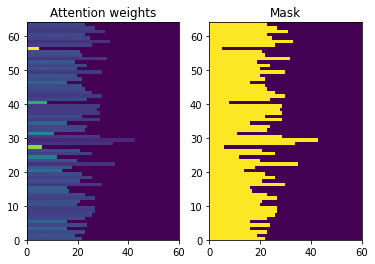

In [27]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 1, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [16]:
#do not run this
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

  
class Decoder2(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder2, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units, dropout=0.25,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    self.gru2 = tf.keras.layers.GRU(self.dec_units, dropout=0.6,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)


  def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  
    #if state is not None:
      
  # Step 1. Lookup the embeddings
    vectors = self.embedding(inputs.new_tokens)
    #shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
    rnn_output, s1 = self.gru(vectors, initial_state=state)
    
    #shape_checker(rnn_output, ('batch', 't', 'dec_units'))
    #shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
    context_vector, attention_weights = self.attention(
        query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  #shape_checker(context_vector, ('batch', 't', 'dec_units'))
  #shape_checker(attention_weights, ('batch', 't', 's'))
  # step 3.5 : Feed the context vectors to rnn 2
    rnn_output, state = self.gru2(context_vector, initial_state=state)
  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
    attention_vector = self.Wc(context_and_rnn_output)
 # shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
    logits = self.fc(attention_vector)
  #shape_checker(logits, ('batch', 't', 'output_vocab_size'))

    return DecoderOutput(logits, attention_weights), state

In [39]:
# run this 

class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

  
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units, dropout=0.25,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    self.gru2 = tf.keras.layers.GRU(self.dec_units, dropout=0.6,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)


  def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  
    #if state is not None:
      
  # Step 1. Lookup the embeddings
    vectors = self.embedding(inputs.new_tokens)
    #shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
    rnn_output, s1 = self.gru(vectors, initial_state=state)
    rnn_output, state = self.gru2(rnn_output, initial_state=state)
    #shape_checker(rnn_output, ('batch', 't', 'dec_units'))
    #shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
    context_vector, attention_weights = self.attention(
        query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  #shape_checker(context_vector, ('batch', 't', 'dec_units'))
  #shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
    attention_vector = self.Wc(context_and_rnn_output)
 # shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
    logits = self.fc(attention_vector)
  #shape_checker(logits, ('batch', 't', 'output_vocab_size'))

    return DecoderOutput(logits, attention_weights), state

In [34]:
decoder = Decoder2((len(tokenizer_en.index_word)+1),
                  embedding_dim, units)

In [30]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = y[:64]

#start_index = token.index('[START]')
first_token = tf.constant([[len(tokenizer_en.index_word)]] * example_output_tokens.shape[0])

In [35]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 35)
state shape: (batch_size, dec_units) (64, 1024)


In [ ]:
sampled_token = tf.random.categorical(dec_result.logits[:,0,:],num_samples=1)
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=sampled_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)


In [40]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    #shape_checker = ShapeChecker()
    #shape_checker(y_true, ('batch', 't'))
    #shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    #shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    #shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

In [41]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_vocab,
               output_text_vocab, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    self.input_text_vocab = input_text_vocab
    self.output_text_vocab = output_text_vocab

    encoder = Encoder((len(self.input_text_vocab)+1),
                      embedding_dim, units)
    decoder = Decoder((len(output_text_vocab)+1),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    
    self.use_tf_function = use_tf_function
    #self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    #self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)
  def _preprocess(self, input_tokens, target_tokens):
    #self.shape_checker(input_text, ('batch',))
    #self.shape_checker(target_text, ('batch',))

    # Convert the text to token IDs
    #input_tokens = self.input_text_processor(input_text)
    #target_tokens = self.output_text_processor(target_text)
    #self.shape_checker(input_tokens, ('batch', 's'))
    #self.shape_checker(target_tokens, ('batch', 't'))

    # Convert IDs to masks.
    input_mask = input_tokens != 0
    #self.shape_checker(input_mask, ('batch', 's'))

    target_mask = target_tokens != 0
    #self.shape_checker(target_mask, ('batch', 't'))

    return input_tokens, input_mask, target_tokens, target_mask
  
  def call(self,inputs):
    input_mask = inputs != 0
    enc_output, enc_state = self.encoder(inputs)
    dec_state = enc_state
    max_len = 60
    output = tf.zeros(shape=[inputs.shape[0], max_len, (len(self.output_text_vocab)+1)],dtype=tf.float32)
    input_token = tf.ones(shape=[inputs.shape[0],1], dtype = tf.int32 ) * self.output_text_vocab['<sos>']
    output = tf.unstack(output,axis=1)
    for i in range(max_len - 1):
      
      decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)
      dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
      input_token = tf.argmax(dec_result.logits,axis=-1) 
      
      
      output[i] = tf.squeeze(dec_result.logits,axis=1)
    
    output = tf.stack(output,axis=1)
      
    return output

  def _train_step(self, inputs):
    input_text, target_text = inputs  

    (input_tokens, input_mask,target_tokens, target_mask) = self._preprocess(input_text, target_text)

    max_target_length = target_tokens.shape[1]

    with tf.GradientTape() as tape:
    # Encode the input
      enc_output, enc_state = self.encoder(input_tokens)
      #self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
      #self.shape_checker(enc_state, ('batch', 'enc_units'))

      #  Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
      dec_state = enc_state
      loss = tf.constant(0.0)

      for t in range(max_target_length-1):
        # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target the target for the decoder's next prediction.
        
        new_tokens = target_tokens[:, t:t+2]
        step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
        loss = loss + step_loss

    # Average the loss over all non padding tokens.
        average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}


  def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
    input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]
    
    # Run the decoder one step.
    decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

    dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
    

    #self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
    #self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
    #self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
    y = target_token
    y_pred = dec_result.logits
    step_loss = self.loss(y, y_pred)

    return step_loss, dec_state
  
  @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.int32, shape=[None,]),
                               tf.TensorSpec(dtype=tf.int32, shape=[None,])]])
  def _tf_train_step(self, inputs):
    return self._train_step(inputs)

In [47]:
embedding_dim, units = 64, 1024
translator = TrainTranslator(
    embedding_dim, units,
    input_text_vocab = tokenizer_hi.word_index,
    output_text_vocab = tokenizer_en.word_index,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)


In [ ]:
for n in range(1):
  print(translator(x[:64]))
print()

In [ ]:
# check save fuctionality
translator.save_weights(filepath="/content/v1weights.h5")
x = translator(x[:2])
translator.load_weights("/content/v1weights.h5")

In [41]:
len(hi[0]), len(en[0])

(64, 72)

In [40]:
embedding_dim =64
units =1024

In [62]:


with strategy.scope():
  translator = TrainTranslator(
    embedding_dim, units,
    input_text_vocab = tokenizer_hi.word_index,
    output_text_vocab = tokenizer_en.word_index,
    use_tf_function=False)

# Configure the loss and optimizer
  translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
  )

In [63]:
training = translator.fit(x=x, y=y, batch_size=128, 
                     epochs=25,  shuffle=True, verbose=1)

Epoch 1/25
175/175 [==============================] - 718s 1s/step - batch_loss: 3.0559
Epoch 2/25
175/175 [==============================] - 37s 212ms/step - batch_loss: 1.9168
Epoch 3/25
175/175 [==============================] - 37s 211ms/step - batch_loss: 1.5095
Epoch 4/25
175/175 [==============================] - 37s 211ms/step - batch_loss: 0.5215
Epoch 5/25
175/175 [==============================] - 37s 211ms/step - batch_loss: 0.3153
Epoch 6/25
175/175 [==============================] - 37s 212ms/step - batch_loss: 0.2688
Epoch 7/25
175/175 [==============================] - 37s 212ms/step - batch_loss: 0.2470
Epoch 8/25
175/175 [==============================] - 37s 212ms/step - batch_loss: 0.2313
Epoch 9/25
175/175 [==============================] - 37s 212ms/step - batch_loss: 0.2186
Epoch 10/25
175/175 [==============================] - 37s 212ms/step - batch_loss: 0.1965
Epoch 11/25
175/175 [==============================] - 37s 212ms/step - batch_loss: 0.1943
Epoch 12/2

In [50]:
translator = training.model

In [ ]:
training_2 = translator.fit(x=x, y=y, batch_size=128, 
                     epochs=10,  shuffle=True, verbose=1)

In [66]:
pth_model = "/content/drive/MyDrive/Dataset/Dakshina/hi/tensorflow/sent_mod_2"
translator_1 = training.model
save_model(translator_1,pth_model)

In [53]:
translator_2 = training_2.model

In [72]:
y[1]

array([33,  5,  4,  2,  2, 18, 14, 21,  2,  2, 21,  5,  3,  9, 14,  6,  2,
        2,  8,  4, 34,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0], dtype=int32)

In [48]:
pth_modell = "/content/drive/MyDrive/Dataset/Dakshina/hi/tensorflow/sent_mod_1/weights.h5"

In [84]:
print(tokenizer_en.sequences_to_texts(tf.argmax(translator_1(x[103:104]),axis=-1).numpy()))
print(tokenizer_en.sequences_to_texts(y[101:104]))

['y a h a n     p a r y a a p t     m a t r a a     m e i n <eos> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>']
['<sos> y a h a n     p a r y a a p t     m a t r a a     m e i n <eos> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>']


In [61]:
translator_2(x[0:1])
translator_2.load_weights(pth_modell)

In [8]:
x = [[2]]


SyntaxError: ignored

In [44]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder,input_tokenizer,output_tokenizer):
    self.encoder = encoder
    self.decoder = decoder
    self.input_tokenizer = input_tokenizer
    self.output_tokenizer = output_tokenizer
    #self.output_token_string_from_index = output_tokenizer.sequences_to_texts()
    #self.output_token_string_from_index = (
     #   tf.keras.layers.experimental.preprocessing.Char(
      #      vocabulary=output_text_vocab,
       #     mask_token='',
       #     invert=True))

    # The output should never generate padding, unknown, or start.
    #index_from_string = tf.keras.layers.experimental.preprocessing.StringLookup(
       # vocabulary=output_tokenizer.word_index, mask_token='')
    token_mask_ids = 0

    token_mask = np.zeros([len(output_tokenizer.word_index)+1], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = output_tokenizer.word_index['<sos>']
    self.end_token = output_tokenizer.word_index['<eos>']

In [47]:
def sample(self, logits, temperature):
  #shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  #shape_checker(logits, ('batch', 't', 'vocab'))
  #shape_checker(self.token_mask, ('vocab',))
  #logits =tf.squeeze(logits,axis=1)
  
  token_mask = self.token_mask[tf.newaxis,tf.newaxis, :]
  
  #shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)

  #shape_checker(new_tokens, ('batch', 't'))

  return new_tokens
def tokens_to_text(self, result_tokens):
  #shape_checker = ShapeChecker()
  #shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_tokenizer.sequences_to_texts(result_tokens.numpy())
  #shape_checker(result_text_tokens, ('batch', 't'))

  #result_text = tf.strings.reduce_join(result_text_tokens,
   #                                    axis=1, separator='')
  #shape_checker(result_text, ('batch'))

  #result_text = tf.strings.strip(result_text)
  #shape_checker(result_text, ('batch',))
  return result_text_tokens
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=False,
                       temperature=0.0):
  
  #print(batch_size)
  input_tokens = self.input_tokenizer.texts_to_sequences(input_text)
  input_tokens = kprocessing.sequence.pad_sequences(input_tokens,padding='post')
  #print(input_tokens.T,input_tokens.T.shape)
  input_tokens= input_tokens.T
  batch_size = input_tokens.shape[0]
  input_tokens = tf.constant(input_tokens)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)
  #print(new_tokens)
  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  
  #print(max_length)
  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)
    #print(dec_result.logits.shape)
    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}


Translator.tokens_to_text = tokens_to_text
Translator.sample = sample
Translator.translate = translate_unrolled

In [77]:
translator = Translator(
    encoder=translator_1.encoder,
    decoder=translator_1.decoder,
    input_tokenizer=tokenizer_hi,
    output_tokenizer=tokenizer_en,
)

In [78]:
ns = [i for i in range(100,200)]
for i in ns:
  print(translator.translate(hi[i]), en[i])

{'text': ['y a h a n     p a r y a p t     m a t r a     m e n s h o s i s t     m e n <UNK>']} yahan  paryaapt  matraa  mein<eos>
{'text': ['h o s i m e n t     k a     n i r m a a n     h o t a a s i s s a y     h o t a a s i n s a y     h']} siment  ka  nirmaan  hota<eos>
{'text': ['h a h a i   .   h a h a i   . <UNK>']} hai.<eos>
{'text': ['y a h     a p n e     s a m a y     k i e s h a y     k i e <UNK>']} yah  apne  samay  ki<eos>


KeyboardInterrupt: ignored

In [28]:
en = df['roman']
hi = df['Hindi']
def shorten(hi,en,max_words):
  new_hi = []
  new_en = []
  for i,j in zip(hi,en):
    hi_wor = i.split(" ")
    en_wor = j.split(" ")
    l=4
    for k in range(0,len(hi_wor)):
      
      if (k%max_words == 0) :
        new_hi.append("  ".join(hi_wor[k:k+l])+ "<eos>")
        new_en.append("  ".join(en_wor[k:k+l])+ "<eos>")
        l=0
      #elif k == len(hi_wor)-1:
      #  new_hi.append(hi_wor[k-l:])
      l+=1
    
  return new_hi,new_en
hi,en = shorten(hi,en,4)